# Определение возраста покупателей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv("/datasets/faces/labels.csv")
print("Размер выборки:", labels.shape[0])

Размер выборки: 7591


In [3]:
labels.info()
labels.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


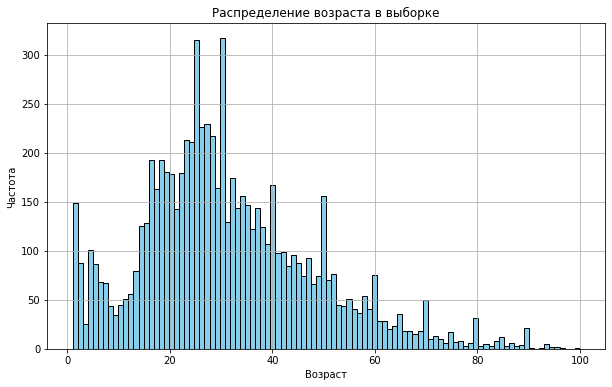

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Как видно большая часть людей в выборке в возрасте 20-30 лет.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


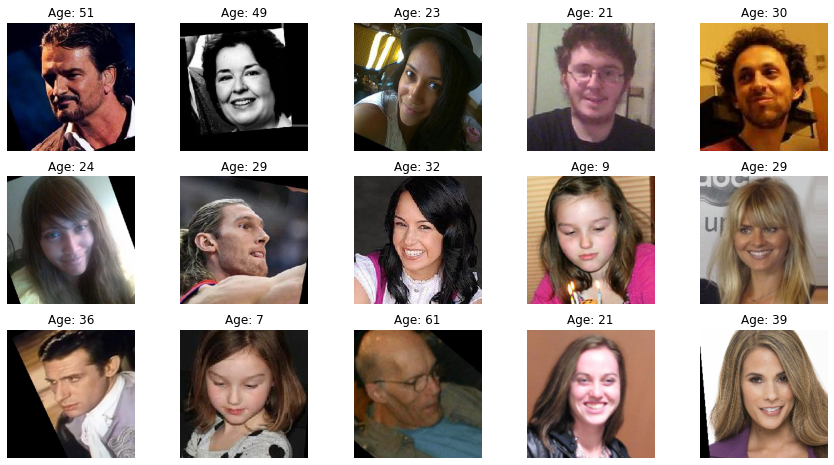

In [6]:
images, labels = [], []
features, target = next(gen_flow)
for features in range(15):
    image, label = gen_flow.next()
    images.append(image)
    labels.append(label)

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i][0])
    plt.title('Age: {}'.format(labels[i][0]))
    plt.axis('off')
plt.show()

Как мы можем заметить в датасете всего 7 тысяч фотографий, чего недостаточно для качественного обучения нейронной сети - перед обучением стоит провести аугментацию. Большая часть людей в возрасте от 17-30, при этом распределние возрастов похоже на нормальное - у нас мало фотографий пожилых людей и маленьких детей. При этом есть аномалии по количеству фотографи людей ровно в 25, 30, 40, 50 и 60 лет, что говорит о не сильно высоком качесвте датасета. В датасете есть как чисто портретные фотографии, так и изображения в полный рост, также стоит заметить что не все фотографии цветные - есть и чёрно белые. Из интересного можно отметить также поворот и размытие некоторых фотографий, как будто в датасете старались собирать центрированные портреты.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + "/labels.csv")
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.2,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + "/labels.csv")
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(1, activation='linear'))

    new_learning_rate = 0.0001
    optimizer = Adam(learning_rate=new_learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/7
2024-04-20 12:15:36.895022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-20 12:15:37.257402: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 63s - loss: 205.3222 - mae: 10.4940 - val_loss: 530.7287 - val_mae: 17.8418
Epoch 2/7
190/190 - 51s - loss: 83.4051 - mae: 6.9628 - val_loss: 461.4215 - val_mae: 16.2310
Epoch 3/7
190/190 - 42s - loss: 54.8357 - mae: 5.5892 - val_loss: 266.7710 - val_mae: 12.2161
Epoch 4/7
190/190 - 51s - loss: 44.9884 - mae: 5.0615 - val_loss: 136.7290 - val_mae: 8.7479
Epoch 5/7
190/190 - 50s - loss: 34.5713 - mae: 4.4579 - val_loss: 74.0121 - val_mae: 6.4550
Epoch 6/7
190/190 - 43s - loss: 30.1666 - mae: 4.1365 - val_loss: 77.3973 - val_mae: 6.8637
Epoch 7/7
190/190 - 51s - loss: 26.5191 - mae: 3.8758 - val_loss: 92.3864 - val_mae: 7.0170
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 92.3864 - mae: 7.0170
Test MAE: 7.0170
```

## Анализ обученной модели

Для работы мы использовали базу в виде ResNet50 и несколько линейных слоёв сверху для решения задачи регрессии и получили неплохой результат - MAE = 7.0170.
* К сожалению возраст для продажи алкоголя с ромощбю получившенйся модели будет определить проблематично - для решения этой проблемы стоит воспользоваться совершенно другими инструментами. 
* Но для задачи рекомендаций модель вполне может подойти, ведь группы по интересам определены достаточно большими интервалами - детство (с рождения до 12 лет), подростковый возраст (с 12 до 18 лет), молодость (с 18 до 35 лет), зрелость (с 35 до 60 лет), пожилой возраст(с 60 лет) и наша модель может их неплохо определять.